In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('BTC-USD-Historical.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume
0,9/17/2014,465.864014,468.174011,452.421997,457.334015,21056800.0
1,9/18/2014,456.859985,456.859985,413.104004,424.440002,34483200.0
2,9/19/2014,424.102997,427.834992,384.532013,394.795990,37919700.0
3,9/20/2014,394.673004,423.295990,389.882996,408.903992,36863600.0
4,9/21/2014,408.084992,412.425995,393.181000,398.821014,26580100.0


In [7]:
df.shape

(3833, 6)

In [8]:
df.describe()

,Open,High,Low,Close,Volume
count,3817.000000,3817.000000,3817.000000,3817.000000,3.817000e+03
mean,20756.389709,21216.753776,20272.964762,20776.986124,1.904677e+10
std,23949.519688,24455.841174,23416.777270,23967.284469,2.075500e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,1317.739990,1327.199951,1292.369995,1317.729980,5.278560e+08
50%,9525.074219,9701.299805,9319.653320,9525.750977,1.516531e+10
75%,33533.199220,34490.390630,32064.814450,33537.175780,3.024206e+10
max,106147.296900,109114.882800,105291.734400,106146.265600,3.510000e+11


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3833 entries, 0 to 3832
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3817 non-null   object 
 1   Open    3817 non-null   float64
 2   High    3817 non-null   float64
 3   Low     3817 non-null   float64
 4   Close   3817 non-null   float64
 5   Volume  3817 non-null   float64
dtypes: float64(5), object(1)
memory usage: 179.8+ KB


### Exploratory Data Analysis (EDA)

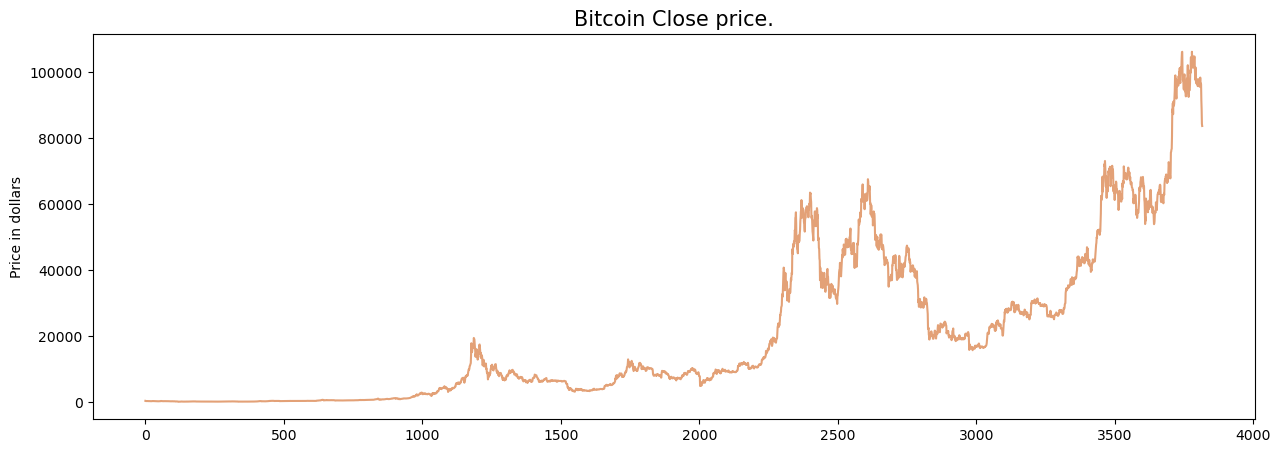

In [10]:
plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='#e3a177')
plt.title('Bitcoin Close price.', fontsize = 15)
plt.ylabel('Price in dollars')
plt.show()


In [11]:
df = df.dropna()
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

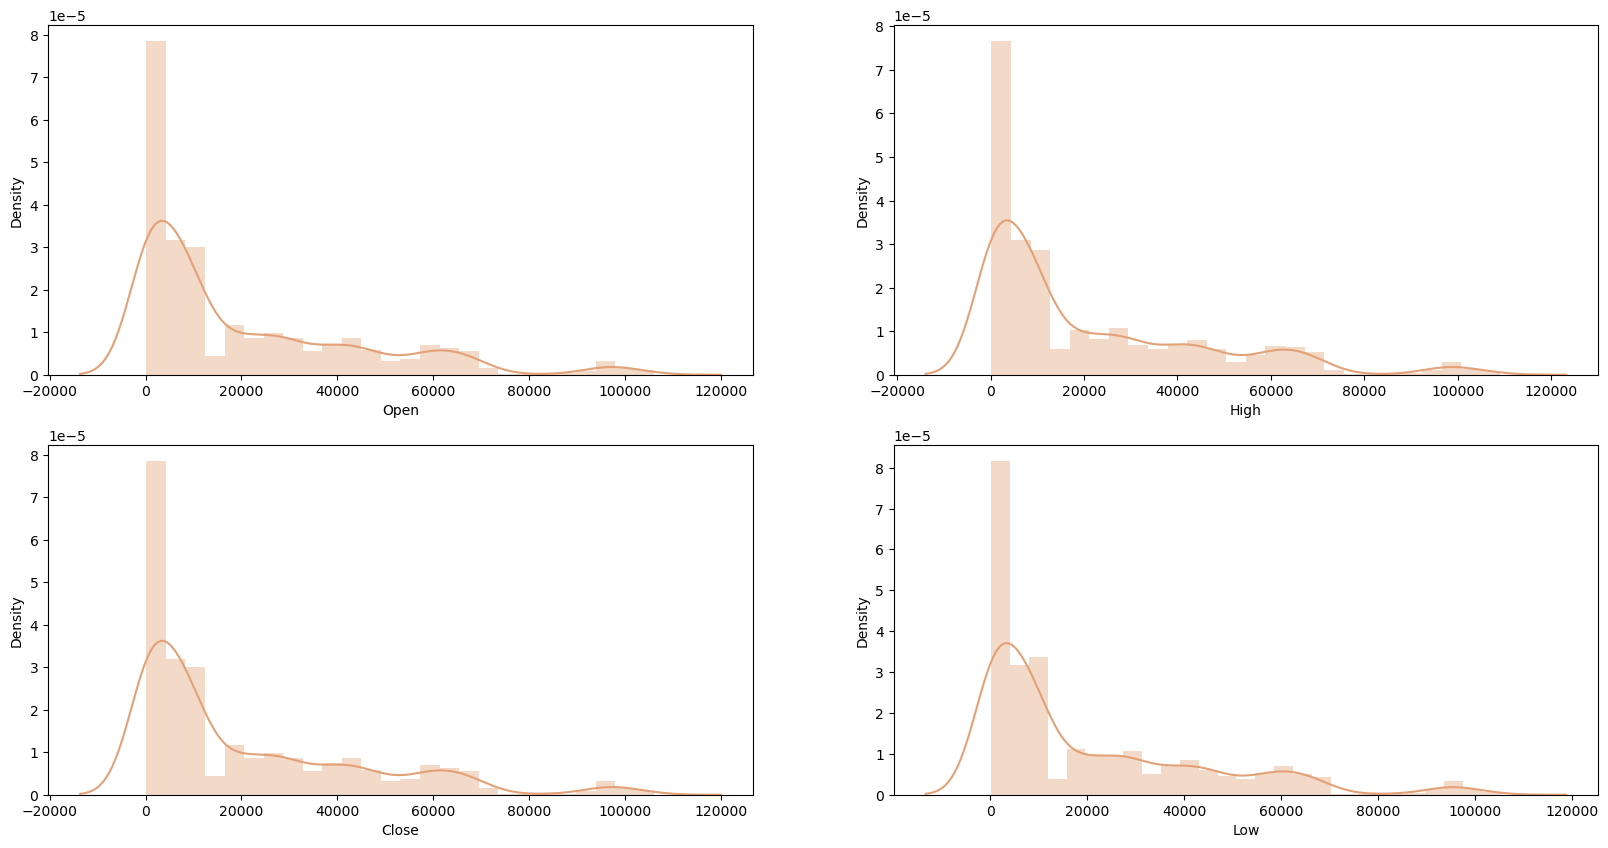

In [12]:
features = ['Open', 'High', 'Close', 'Low']

plt.subplots(figsize = (20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.distplot(df[col], color='#e3a177')
plt.show()


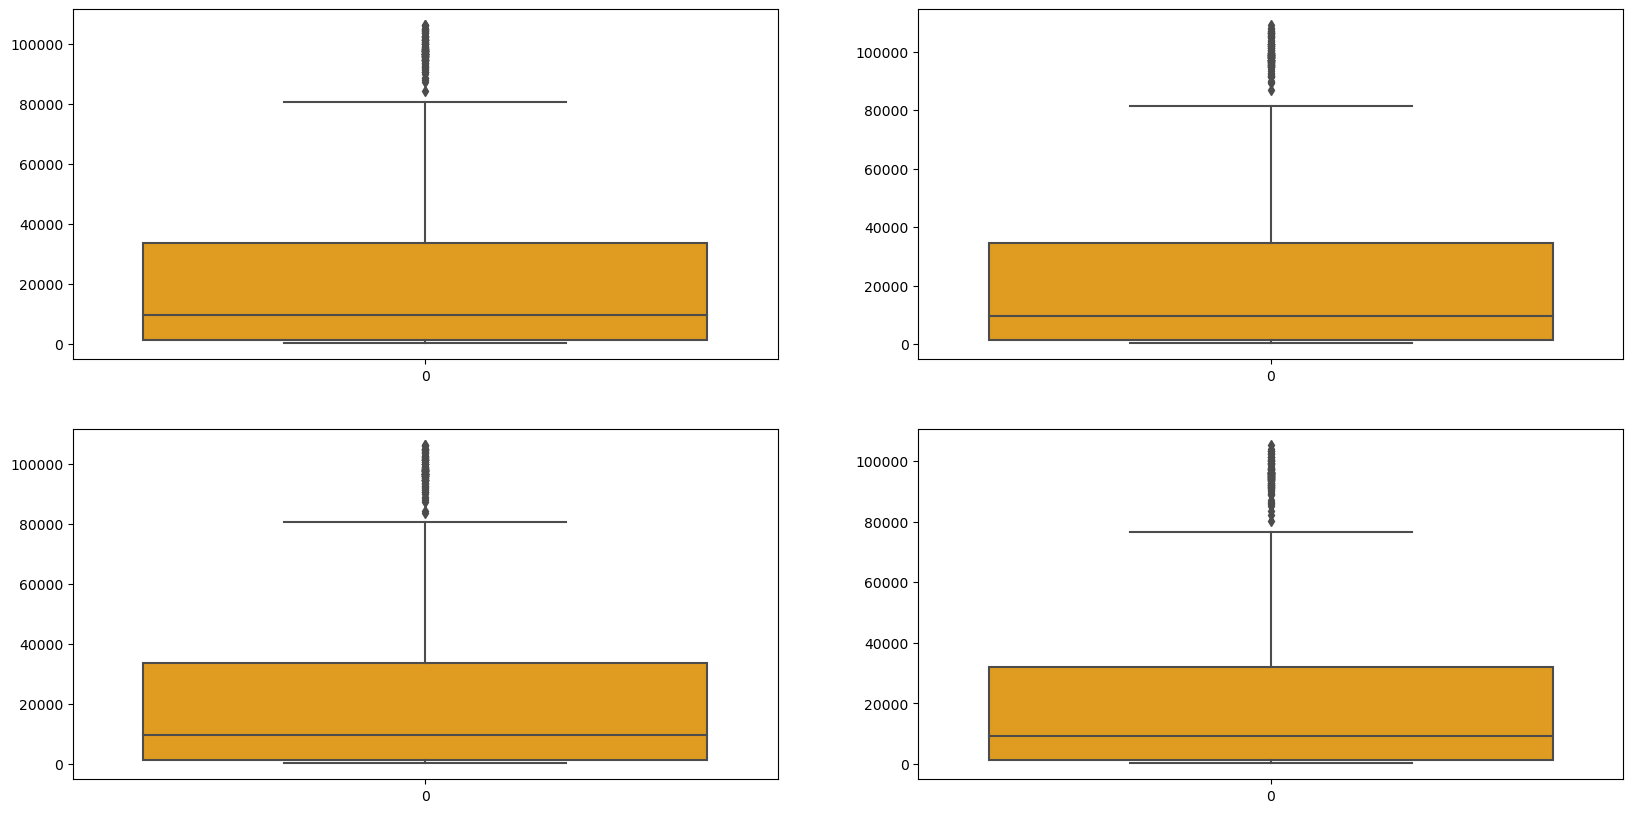

In [13]:
plt.subplots(figsize = (20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.boxplot(df[col], color = "Orange")
plt.show()


In [14]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce') 

# Display the result
# Extract year, month, and day in the table
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Convert to integers 
df['Year'] = df['Year'].astype('Int64')
df['Month'] = df['Month'].astype('Int64')
df['Day'] = df['Day'].astype('Int64')

df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,2014,9,18
2,2014-09-19,424.102997,427.834992,384.532013,394.795990,37919700.0,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,2014,9,20
4,2014-09-21,408.084992,412.425995,393.181000,398.821014,26580100.0,2014,9,21


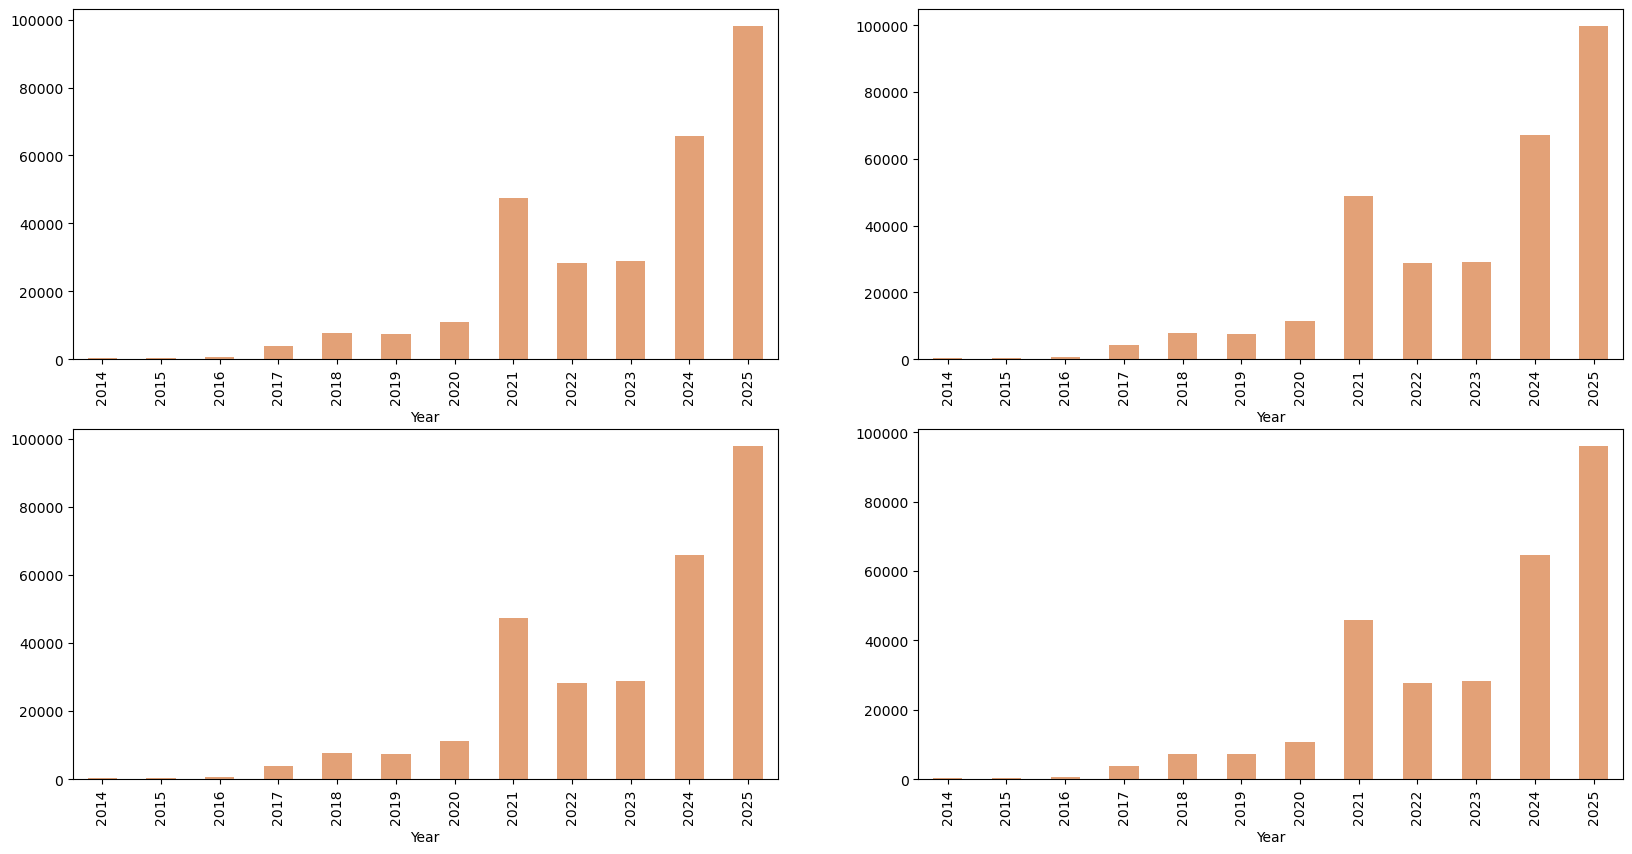

In [15]:
data_grouped = df.groupby('Year').mean()
plt.subplots(figsize = (20,10))
for i, col in enumerate(['Open', 'High', 'Close', 'Low']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar(color='#e3a177')
plt.show()


In [16]:
df['is_Quarter_End'] = (df['Month'] % 3 == 0).astype('Int64')
df.head()


,Date,Open,High,Low,Close,Volume,Year,Month,Day,is_Quarter_End
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,2014,9,18,1
2,2014-09-19,424.102997,427.834992,384.532013,394.795990,37919700.0,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,2014,9,20,1
4,2014-09-21,408.084992,412.425995,393.181000,398.821014,26580100.0,2014,9,21,1


In [17]:
df['Open-Close']  = df['Open'] - df['Close']
df['Low-High']  = df['Low'] - df['High']
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)


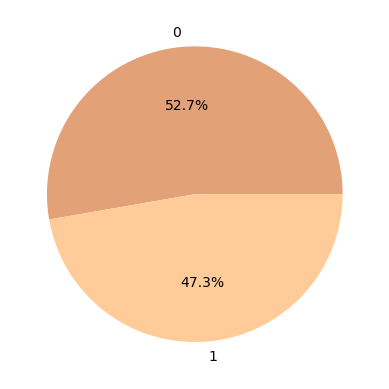

In [18]:
labels = [0, 1]

plt.pie(df['Target'].value_counts().values, 
        labels = labels, autopct = '%1.1f%%', colors = ['#e3a177','#ffcc99'], radius = 1)

plt.show()


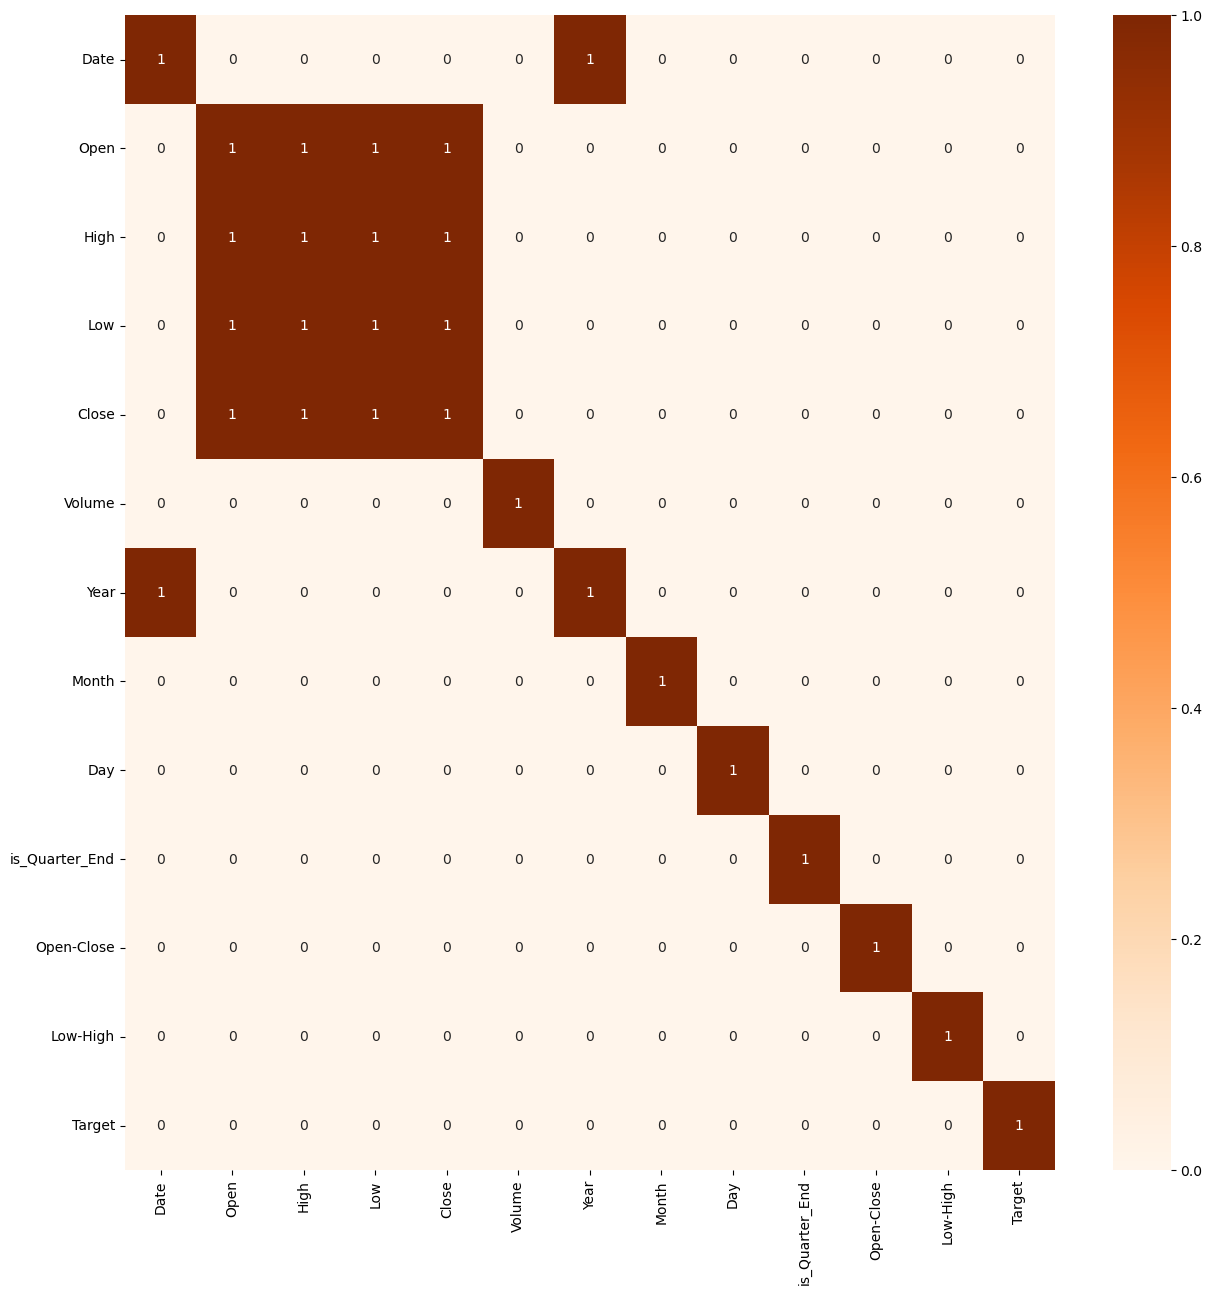

In [19]:
# Compute the correlation matrix
# Set a threshold to filter highly correlated features
correlation_matrix = df.corr()
threshold = 0.9
mask = (correlation_matrix > threshold) 

plt.figure(figsize=(15, 15))  
sns.heatmap(mask, annot = True, cmap = 'Oranges')
plt.show()
